# Multilayer Attribute-based Conflict-reducing Observation

This notebook shows an example usage of the Multilayer Attribute-based Conflict-reducing
Observation (MACRO) implementation. Data is generated randomly, and the MACRO classifier
is trained with the first 100 generated datapoints and "evaluated" on the remaining
datapoints. For information on MACRO see:

[Mön17] - U. Mönks, "Information Fusion Under Consideration of Conflicting Input Signals"

## Setup and data generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ml4proflow.modules import DataFlowManager
from ml4proflow_mods.informationfusion.modules import (MACROAttribute, MultilayerAttributeBasedConflictReducingObservation)

class Sensor:
    """
    Implementation of a sensor simulation. Artificial generated sensor data can be
    generated. Sensor drift, noise, and random outliers (= sensor errors) can be
    simulated.
    """
    def __init__(self,
                 basevalue: float = 1.0,
                 offset: float = 0,
                 noise_max: float = 0.1,
                 drift_rate: float = 0.001,
                 prob_change_drift: float = 0.005,
                 peak_factor: float = 0.5,
                 prob_peak: float = 0.01):
        """
        Create a new simulated sensor.
        :param basevalue: The ground truth of the sensor (static).
        :param offset: The offset (= epistemic measurement error).
        :param noise_max: The maximum noise added to the sensor.
        The noise is uniformly distributed.
        :param drift_rate: The drift rate of the sensor per sample.
        :param prob_change_drift: The probability that the drift direction changes.
        :param peak_factor: Factor of a simulated peak/measurement error. Scales the
        current value.
        :param prob_peak: The probability that a peak occurs.
        """
        self.basevalue = basevalue
        self.offset = offset
        self.noise_max = noise_max
        self.drift_rate = drift_rate
        self.prob_change_drift = prob_change_drift
        self.peak_factor = peak_factor
        self.prob_peak = prob_peak

    def generate_data(self, n: int) -> np.ndarray:
        """
        Generate n consecutive datapoints for this sensor. The initial drift direction
        is randomly chosen.

        :param n: The number of datapoints to generate.
        :return: The generated datapoints.
        """
        datapoints = np.ones(n) * self.basevalue + self.offset
        rng = np.random.default_rng(seed=4224)
        rfloat = rng.random()
        if rfloat < 0.5:
            drift_direction = 1
        else:
            drift_direction = -1
        drift_value = 0
        for i in range(n):
            # Random noise:
            rfloat = rng.random()
            noise = self.noise_max * 2 * rfloat - self.noise_max
            # Cange drift direction?
            if rng.random() < self.prob_change_drift:
                drift_direction *= -1
            # Drift:
            drift_value += drift_direction * self.drift_rate
            datapoints[i] += drift_value + noise
            # Peak ?
            if rng.random() < self.prob_peak:
                if rng.random() < 0.5:
                    datapoints[i] += datapoints[i] * self.peak_factor
                else:
                    datapoints[i] -= datapoints[i] * self.peak_factor
        return datapoints

### Sensor class test

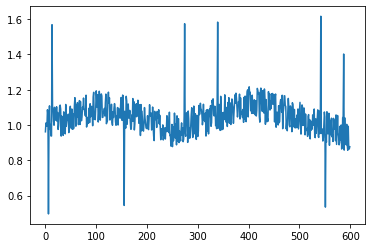

In [2]:
sensor = Sensor()
fig, ax = plt.subplots()
ax.plot(sensor.generate_data(600))

## MACRO test

### Create sensors and generate data
Data for a period of 6s is generated. The values of the first 0.6 seconds are used for
training. Currently, each attribute layer expects the same number of samples for each
feature. For now upsample all features of one attribute layer to the least common
multiple of the sampling rates by repetition of values as a workaround.

In [3]:
# Cylinder 1, upsample data to 600 HZ
cyl1_current = Sensor(basevalue=2.5, noise_max=0.2, peak_factor=0.2, prob_peak=0.002)
c1c_data = cyl1_current.generate_data(1200)
c1c_data = np.repeat(c1c_data, 3)
# mean as feature, 200 Hz
cyl1_temperature = Sensor(basevalue=20, noise_max=0.2, peak_factor=0.2, prob_peak=0.002)
c1t_data = cyl1_temperature.generate_data(120)
c1t_data = np.repeat(c1t_data, 30)
# mean as feature, 20 Hz
cyl1_speed = Sensor(basevalue=685, noise_max=0.001, peak_factor=0.2, prob_peak=0.002)
c1s_data = cyl1_speed.generate_data(1800)
c1s_data = np.repeat(c1s_data, 2)
# Standard Dev. as feature, 300 Hz
cyl1_vibration = Sensor(basevalue=32.4, noise_max=0.01, peak_factor=0.2, prob_peak=0.002)
c1v_data = cyl1_vibration.generate_data(1800)
c1v_data = np.repeat(c1v_data, 2)
# standard dev. as feature, 300 Hz
cyl1_brightness = Sensor(basevalue=50, noise_max=0.3, peak_factor=0.6, prob_peak=0.002)
c1b_data = cyl1_brightness.generate_data(1200)
c1b_data = np.repeat(c1b_data, 3)
# mean as feature, std. dev. as feature, 200 Hz

# Cylinder 2, upsample data to 600 HZ
cyl2_current = Sensor(basevalue=1.02, noise_max=0.03, peak_factor=0.2, prob_peak=0.002)
c2c_data = cyl2_current.generate_data(1200)
c2c_data = np.repeat(c2c_data, 3)
# mean as feature, 200 Hz
cyl2_temperature = Sensor(basevalue=19.9, noise_max=0.15, peak_factor=0.15, prob_peak=0.001)
c2t_data = cyl2_temperature.generate_data(120)
c2t_data = np.repeat(c2t_data, 30)
# mean as feature, 20 Hz
cyl2_speed = Sensor(basevalue=912, noise_max=0.04, peak_factor=0.2, prob_peak=0.002)
c2s_data = cyl2_speed.generate_data(1800)
c2s_data = np.repeat(c2s_data, 2)
# Standard Dev. as feature, 300 Hz
cyl2_vibration = Sensor(basevalue=37.4, noise_max=0.02, peak_factor=0.2, prob_peak=0.002)
c2v_data = cyl2_vibration.generate_data(1800)
c2v_data = np.repeat(c2v_data, 2)
# standard dev. as feature, 300 Hz
cyl2_force = Sensor(basevalue=8, noise_max=0.01, peak_factor=0.3, prob_peak=0.08)
c2f_data = cyl2_force.generate_data(1200)
c2f_data = np.repeat(c2f_data, 3)
# mean as feature, std. dev. as feature, 200 Hz

## Create the Attributes
Create the attributes cylinder 1, cylinder 2 and other and train the attribute layer.

In [4]:
# Cylinder 1
cyl1_data = np.stack([c1c_data, c1t_data, c1s_data, c1v_data, c1b_data], axis=-1)
cyl1_attr = MACROAttribute(None, {'mode': 'fit', 'pcel': 0.5, 'pcer': 0.5, 'dl': 20, 'dr': 20})
c1_train_data = cyl1_data[:720]
cyl1_attr.fit(c1_train_data)
cyl1_attr.update_config('mode', 'predict')

# Cylinder 2
cyl2_data = np.stack([c2c_data, c2t_data, c2s_data, c2v_data, c2f_data], axis=-1)
cyl2_attr = MACROAttribute(None, {'mode': 'fit',  'pcel': 0.5, 'pcer': 0.5, 'dl': 20, 'dr': 20})
c2_train_data = cyl2_data[:720]
cyl2_attr.fit(c2_train_data)
cyl2_attr.update_config('mode', 'predict')

## Create the System Layer Fusion

In [5]:
system_monitor = MultilayerAttributeBasedConflictReducingObservation(DataFlowManager(), {
    'andness': 0.5,
    'n_attributes': 2,
    'batchsize': cyl1_data.shape[0]
})

print(system_monitor.get_applied_andness(system_monitor.weights))

0.5


In [6]:
_, ax = plt.subplots()
cyl1_memberships = cyl1_attr.fuse_samples(cyl1_data)
cyl2_memberships = cyl2_attr.fuse_samples(cyl2_data)
ax.plot(system_monitor.get_system_health([cyl1_memberships, cyl2_memberships]))
ax.set_ylim([0, 1])

(0.0, 1.0)

(0.0, 1.0)

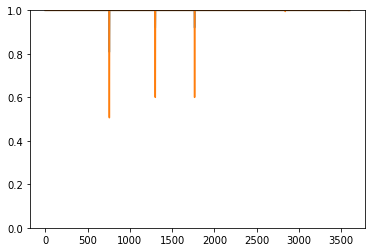

In [7]:
_, ax = plt.subplots()
ax.plot(cyl1_attr.fuse_samples(cyl1_data))
ax.set_ylim([0, 1])

(0.0, 1.0)

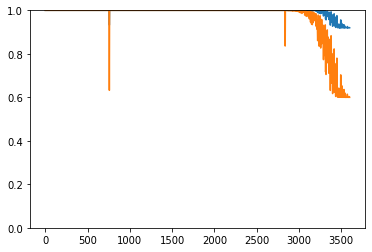

In [8]:
_, ax = plt.subplots()
ax.plot(cyl2_attr.fuse_samples(cyl2_data))
ax.set_ylim([0, 1])

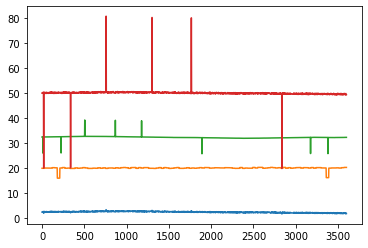

In [9]:
_, ax = plt.subplots()
ax.plot(c1c_data)
ax.plot(c1t_data)
#ax.plot(c1s_data)
ax.plot(c1v_data)
ax.plot(c1b_data)

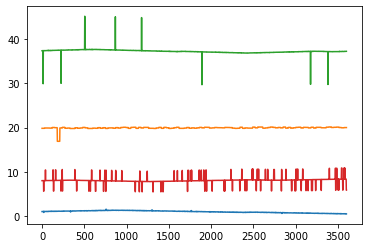

In [10]:
_, ax = plt.subplots()
ax.plot(c2c_data)
ax.plot(c2t_data)
#ax.plot(c2s_data)
ax.plot(c2v_data)
ax.plot(c2f_data)